In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import gc
import json
from scipy.optimize import curve_fit
import datetime
from pathlib import Path

import plotly.express as px
from urllib.request import urlopen



In [7]:
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 50)

In [8]:
df = pd.read_csv('https://query.data.world/s/keax53lpqwffhayvcjmowjiydtevwo', parse_dates=['REPORT_DATE']).copy()


In [9]:
print("date range: {0} to {1}".format(df['REPORT_DATE'].min(), df['REPORT_DATE'].max()))

date range: 2019-12-31 00:00:00 to 2020-10-18 00:00:00


# Global Trends

In [10]:
df_cp = df.groupby(['REPORT_DATE','COUNTRY_SHORT_NAME']).sum()[
    [
        'PEOPLE_POSITIVE_CASES_COUNT', 
        'PEOPLE_POSITIVE_NEW_CASES_COUNT', 
        'PEOPLE_DEATH_COUNT', 
        'PEOPLE_DEATH_NEW_COUNT'
    ]
]
df_cp['MORTALITY_RATIO'] = df_cp['PEOPLE_DEATH_COUNT']/df_cp['PEOPLE_POSITIVE_CASES_COUNT']
df_cp = df_cp.unstack().copy()

In [11]:
top_10c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:10].index.values
top_25c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:25].index.values

In [12]:
df_countrypop = pd.read_csv('/Users/dcripe/dev/code/notebooks/data_common/world_pop_2020.csv')

In [13]:
df_cppop = df_cp.iloc[-5:-1].max().swaplevel(0,1).unstack().merge(df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')
df_cppop_lg = df_cppop[df_cppop['population'] > 10000000]

In [23]:
REF_CTRY = ['Sweden', 'United States', 'Germany']

In [19]:
per_x = 100000

In [20]:
top_10c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:10].index.values
top_25c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:25].index.values

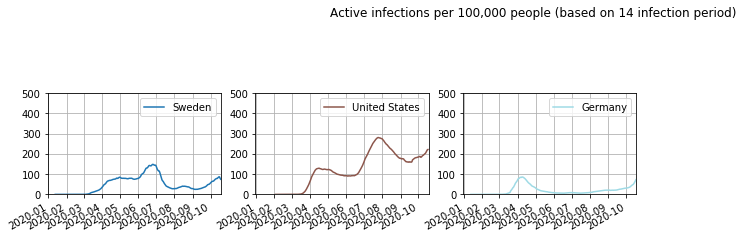

In [24]:
# df_trc = df.groupby(['Date','Country_Region','Case_Type']).agg({'Cases':sum,'Population_Count':sum})

df_rinfc = df_cp.xs('PEOPLE_POSITIVE_NEW_CASES_COUNT', axis=1, level=0)[REF_CTRY].rolling(window=14).sum().T.merge(
    df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')

(df_rinfc[df_rinfc.columns[0:-2]].div(df_rinfc[df_rinfc.columns[-1]], axis=0)*per_x).T.plot(
    subplots=True, 
    ylim=(0,500),
#     logy=True,
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
    cmap='tab20',
    title='Active infections per {0:,} people (based on 14 infection period)'.format(per_x)
);

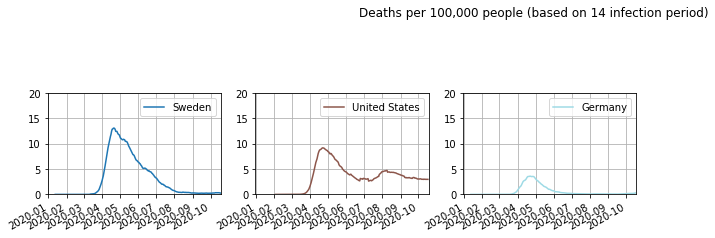

In [29]:
df_rmorc = df_cp.xs('PEOPLE_DEATH_NEW_COUNT', axis=1, level=0)[REF_CTRY].rolling(window=14).sum().T.merge(
    df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')

(df_rmorc[df_rmorc.columns[0:-2]].div(df_rmorc[df_rmorc.columns[-1]], axis=0)*per_x).T.plot(
    subplots=True, 
    ylim=(0,20),
#     logy=True,
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
    cmap='tab20',
    title='Deaths per {0:,} people (based on 14 infection period)'.format(per_x)
);

In [41]:
df_infref = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0)[REF_CTRY].iloc[0:-2].T.merge(
    df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')

In [43]:
df_infref[df_infref.columns[-3]].div(df_infref[df_infref.columns[-1]], axis=0)*100

country
Sweden          1.022
United States   2.444
Germany         0.416
dtype: float64

In [36]:
df_morref = df_cp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0)[REF_CTRY].iloc[0:-2].T.merge(
    df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')

In [42]:
df_morref[df_morref.columns[-3]].div(df_morref[df_morref.columns[-1]], axis=0)*100

country
Sweden          0.059
United States   0.066
Germany         0.012
dtype: float64

In [68]:
# Global
print("Global cases: {0:,}".format(df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-2].sum()))
print("Global deaths: {0:,}".format(df_cp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[-2].sum()))

Global cases: 39,449,674.0
Global deaths: 1,104,369.0


In [66]:
# Global cases
print("Global cases: {0:,}".format(df_cp.xs('PEOPLE_POSITIVE_NEW_CASES_COUNT', axis=1, level=0).iloc[0:-1].sum(axis=1).sum()))
print("Global deaths: {0:,}".format(df_cp.xs('PEOPLE_DEATH_NEW_COUNT', axis=1, level=0).iloc[0:-1].sum(axis=1).sum()))

Global cases: 39,449,674.0
Global deaths: 1,104,369.0


The graphs below show the growth trends by country. Note that the left axis is not standardized between states so it's important to look at the magnitude.  Also note that this depends on accurate reporting by the countried themselves, which is questionable in some cases.

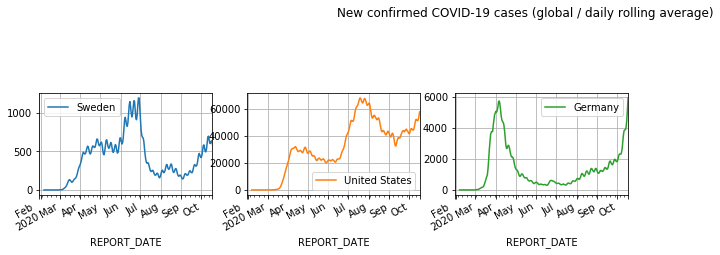

In [25]:
df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[30::][REF_CTRY].rolling(window=5).mean().diff().rolling(3).mean().plot(
    subplots=True, 
#     ylim=(-25,100), 
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
#     cmap='tab20',
    title='New confirmed COVID-19 cases (global / daily rolling average)'
);
plt.savefig('./out/covid_cases_global_trends.png');

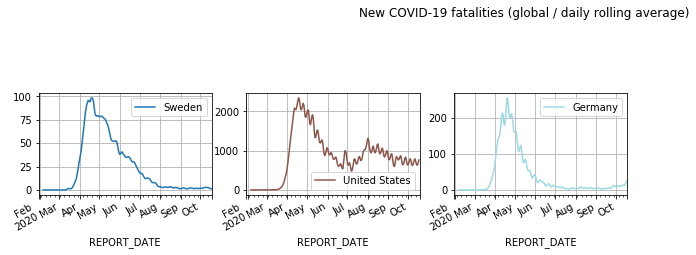

In [26]:
df_cp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[30::][REF_CTRY].rolling(window=5).mean().diff().rolling(3).mean().plot(
    subplots=True, 
#     ylim=(-25,100), 
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
    cmap='tab20',
    title='New COVID-19 fatalities (global / daily rolling average)'
);
# fig.write_image('./out/covid_deaths_global_trend.png');

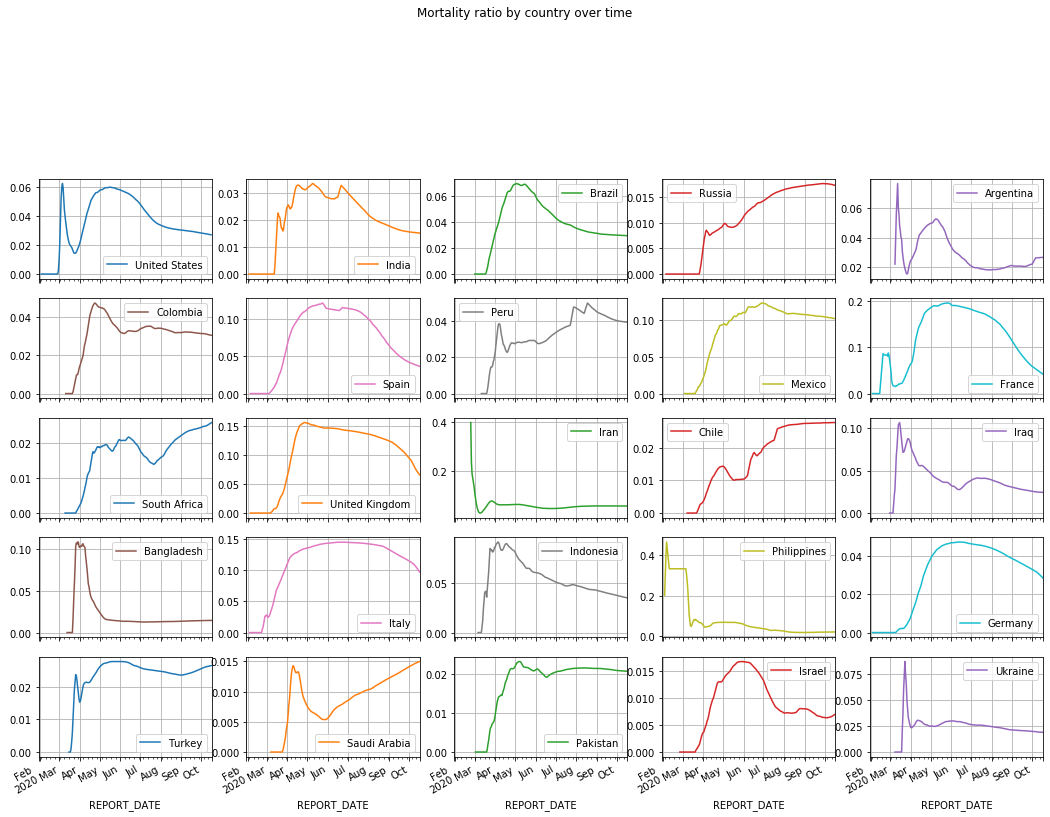

In [12]:
df_cp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::][top_25c].rolling(window=5).mean().plot(
    subplots=True, 
#     ylim=(-10,25), 
    layout=(10,5), 
    figsize=(18,24),
    grid=True, 
    title='Mortality ratio by country over time',
);